In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from hazm import *
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import svm,metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

#### Load Persica Data

In [2]:
file_open = open('persica.csv')
file = file_open.readlines()
file_open.close()

#### Preprocessing of persica

In [3]:
for i in range(len(file)):
    file[i] =  file[i].replace('\n','')
    file[i] =  file[i].replace(',','')

In [4]:
category = []
news_subcategory = []
news_title = []
news_text = []
news_id = []
for i in range(0,len(file),7):
    news_id.append(file[i].replace('\ufeff',''))
    news_title.append(file[i+1])
    news_text.append(file[i+2])
    news_subcategory.append(file[i+5][:-1])
    category.append(file[i+6])

In [5]:
for subject in set(category):
    print(f'Count of news in subject {subject} = {list.count(category,subject)}')

Count of news in subject فقه و حقوق = 1000
Count of news in subject فرهنگي = 1000
Count of news in subject ورزشي = 1000
Count of news in subject آموزشي = 1000
Count of news in subject علمي = 1000
Count of news in subject مذهبي = 1000
Count of news in subject اقتصادي = 1000
Count of news in subject بهداشتي = 1000
Count of news in subject تاريخي = 999
Count of news in subject سياسي = 1000
Count of news in subject اجتماعي = 1000


In [6]:
d = {'news_id': news_id, 'news_title': news_title, 'news_text': news_text, 'news_subcategory': news_subcategory , 'news_category': category}
df = pd.DataFrame(data=d)
df.head()

news_id                                         news_title  \
0  843656  وزير علوم درجمع استادان نمونه: سن بازنشستگي اس...   
1  837144  گردهمايي دانش‌آموختگان موسسه آموزش عالي سوره ب...   
2  436862  نتايج آزمون دوره‌هاي فراگير دانشگاه پيام‌نور ا...   
3  227781  همايش يكروزه آسيب شناسي مفهوم روابط عمومي در ب...   
4  174187  وضعيت اقتصادي و ميزان تحصيلات والدين از مهمتري...   

                                           news_text news_subcategory  \
0  وزير علوم در جمع استادان نمونه كشور گفت: از اس...           آموزشي   
1  به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...           آموزشي   
2  نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...           آموزشي   
3                                                     اجتماعي-خانواده   
4  محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...           آموزشي   

  news_category  
0        آموزشي  
1        آموزشي  
2        آموزشي  
3       اجتماعي  
4        آموزشي

In [7]:
le = LabelEncoder()
le.fit(list(set(category)))
df['news_category'] = le.transform(df['news_category'])
df.head()

news_id                                         news_title  \
0  843656  وزير علوم درجمع استادان نمونه: سن بازنشستگي اس...   
1  837144  گردهمايي دانش‌آموختگان موسسه آموزش عالي سوره ب...   
2  436862  نتايج آزمون دوره‌هاي فراگير دانشگاه پيام‌نور ا...   
3  227781  همايش يكروزه آسيب شناسي مفهوم روابط عمومي در ب...   
4  174187  وضعيت اقتصادي و ميزان تحصيلات والدين از مهمتري...   

                                           news_text news_subcategory  \
0  وزير علوم در جمع استادان نمونه كشور گفت: از اس...           آموزشي   
1  به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...           آموزشي   
2  نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...           آموزشي   
3                                                     اجتماعي-خانواده   
4  محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...           آموزشي   

   news_category  
0              0  
1              0  
2              0  
3              1  
4              0

In [8]:
for ind, cls in enumerate(le.classes_):
    print(f'The number corresponding to the {cls} is:  \t {ind}')

The number corresponding to the آموزشي is:  	 0
The number corresponding to the اجتماعي is:  	 1
The number corresponding to the اقتصادي is:  	 2
The number corresponding to the بهداشتي is:  	 3
The number corresponding to the تاريخي is:  	 4
The number corresponding to the سياسي is:  	 5
The number corresponding to the علمي is:  	 6
The number corresponding to the فرهنگي is:  	 7
The number corresponding to the فقه و حقوق is:  	 8
The number corresponding to the مذهبي is:  	 9
The number corresponding to the ورزشي is:  	 10


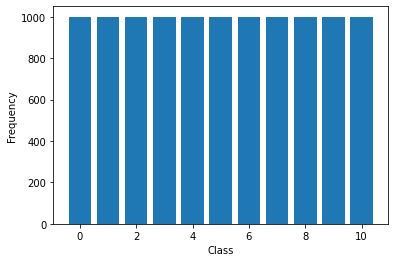

In [9]:
x = np.array([ind for ind,cls in enumerate(le.classes_)])
y = np.array([list.count(category,subject) for subject in set(category)])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.bar(x,y)
plt.show()

--------------

#### Read and normalize Persian stopwords

In [10]:
normalizer = Normalizer()
from PersianStemmer import PersianStemmer
ps = PersianStemmer()

In [11]:
file_open = open('stop.txt','r')
file_stopwords = file_open.readlines()
file_open.close()

In [12]:
file_stopwords = [normalizer.normalize(ps.run(x.replace('\n','').replace('_',' ').replace('\u200f','').replace('\x7f',''))) for x in file_stopwords]
file_stopwords

['و',
 'در',
 'به',
 'از',
 'که',
 'این',
 'را',
 'با',
 'است',
 'برای',
 'آن',
 'یک',
 'خود',
 'تا',
 'کرد',
 'بر',
 'هم',
 'نیز',
 'گفت',
 'می\u200cشود',
 'وی',
 'شد',
 'دارد',
 'ما',
 'اما',
 'یا',
 'شده',
 'باید',
 'هر',
 'آنها',
 'بود',
 'او',
 'دیگر',
 'دو',
 'مورد',
 'می\u200cکند',
 'شود',
 'کند',
 'وجود',
 'بین',
 'پیش',
 'شده',
 'پس',
 'نظر',
 'اگر',
 'همه',
 'یکی',
 'حال',
 'هست',
 'من',
 'کنند',
 'نیست',
 'باشد',
 'چه',
 'بی',
 'می',
 'بخش',
 'می\u200cکنند',
 'همین',
 'افزود',
 'هایی',
 'دار',
 'راه',
 'همچنین',
 'روی',
 'داد',
 'بیشتر',
 'بسیار',
 'سه',
 'داشت',
 'چند',
 'سو',
 'تنها',
 'هیچ',
 'میان',
 'اینکه',
 'شدن',
 'بعد',
 'جدید',
 'ولی',
 'حتی',
 'کردن',
 'برخی',
 'کرد',
 'می\u200cدهد',
 'اول',
 'نه',
 'کرده',
 'نسبت',
 'بیش',
 'شما',
 'چنین',
 'طور',
 'فرد',
 'تمام',
 'درباره',
 'بار',
 'بسیار',
 'می\u200cتواند',
 'کرده',
 'چون',
 'ندارد',
 'دوم',
 'بزرگ',
 'طی',
 'حد',
 'همان',
 'بدون',
 'البته',
 'آنان',
 'می\u200cگوید',
 'دیگری',
 'خواهد شد',
 'کنیم',
 'قابل',
 '

In [13]:
len(file_stopwords)

389

In [14]:
notations = ['!','»','،','؛','؟','"','#','(',')','*',',','-','.','/',':','[',']','«','…']

In [15]:
listt = []
for x in df['news_text']:
    #listt.append(normalizer.normalize(x)) TESTED - BAD
    listt.append(x)
    for notation in notations:
        listt[-1] = listt[-1].replace(notation,'')
    for stop in file_stopwords:
        listt[-1] = listt[-1].replace(' '+stop+' ',' ')
    listt[-1] = listt[-1].replace('&nbsp;',' ').replace('_',' ')

In [16]:
df['news_text'] = listt

-----------------

#### Split Training and testing set

In [17]:
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,2],df.iloc[:,-1],test_size=0.2,random_state=0)

#### Normalize Train and Test

In [18]:
News_Tokenized_Train = [word_tokenize(x) for x in X_train]
News_Tokenized_Test = [word_tokenize(x) for x in X_test]

In [20]:
News_Tokenized_Train

[['ثبت\u200cنام',
  'آزمون',
  'كارداني',
  'پيوسته',
  '1382',
  'دانشگاه',
  'آزاد',
  'اسلامي',
  'روز',
  'شنبه',
  '12',
  'بهمن',
  'ماه',
  'جاري',
  'آغاز',
  'مي\u200cشود',
  'گزارش',
  'سرويس',
  'آموزشي',
  'خبرگزاري',
  'دانشجويان',
  'ايران',
  'ايسنا',
  'داوطلبان',
  'علاقمند',
  'شركت',
  'آزمون',
  'كارداني',
  'پيوسته',
  '1382',
  'اين',
  'دانشگاه',
  'مي',
  'توانند',
  'روز',
  'شنبه',
  '12',
  'بهمن',
  'لغايت',
  'روز',
  'پنجشنبه',
  '8',
  'اسفند',
  'ماه',
  'جاري',
  'مراجعه',
  'دفاتر',
  'باجه\u200cهاي',
  'پستي',
  'كشور',
  'تهيه',
  'دفترچه',
  'راهنما',
  'ضمائم',
  'ثبت',
  'نام',
  'اقدام',
  'نمايند',
  'گفتني',
  'آزمون',
  'كارداني',
  'پيوسته',
  'دانشكاه',
  'آزاد',
  'اسلامي',
  '26',
  'رشته',
  'روز',
  'مرداد',
  'ماه',
  '1382',
  'همزمان',
  '127',
  'حوزه',
  'دانشگاهي',
  'برگزار',
  'مي\u200cشود',
  'چهل',
  'هفتمين',
  'روساي',
  'دانشگاهها',
  'مراكز',
  'علمي',
  'تحقيقاتي',
  'فردا',
  'روز',
  'دانشگاه',
  'صنعتي',
  'اصفهان',
  '

In [21]:
listt = []
for x in News_Tokenized_Train:
    listt.append( ' '.join([ps.run(s).replace(' ','\u200c') for s in x if s!=' ']))
    #listt.append( ' '.join([s.replace(' ','\u200c').replace('ي','ی').replace('ك','ک') for s in x if s!=' ']))
X_train = listt

listt = []
for x in News_Tokenized_Test:
    listt.append( ' '.join([ps.run(s).replace(' ','\u200c') for s in x if s!=' ']))
    #listt.append( ' '.join([s.replace(' ','\u200c').replace('ي','ی').replace('ك','ک') for s in x if s!=' ']))
X_test = listt

#### Tf-Idf Vectorization

In [22]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
TF_IDF_XTrain = vectorizer.fit_transform(list(X_train))
TF_IDF_XTest = vectorizer.transform(list(X_test))

In [23]:
TF_IDF_XTrain.shape

(8799, 62865)

In [24]:
svd = TruncatedSVD(n_components=500, random_state=0)
svd.fit(TF_IDF_XTrain)
LSA_Train = svd.transform(TF_IDF_XTrain)
LSA_Test = svd.transform(TF_IDF_XTest)

In [25]:
LSA_Train.shape

(8799, 500)

### Perform Classifications on vectorized tf-idf

#### SVM

In [26]:
clf = svm.SVC(kernel='rbf')
Hist_SVM = clf.fit(LSA_Train, y_train)

In [27]:
print(f'Accuracy on Train Data = {clf.score(LSA_Train,y_train)*100}%')
print(f'Accuracy on Test Data = {clf.score(LSA_Test,y_test)*100}%')

Accuracy on Train Data = 93.76065461984317%
Accuracy on Test Data = 84.63636363636363%


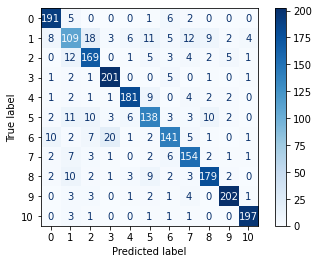

In [28]:
cm = confusion_matrix(y_test, clf.predict(LSA_Test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.savefig('SVMConfusion.png', dpi=300)
plt.show()

In [41]:
print(metrics.classification_report(y_test, clf.predict(LSA_Test)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       205
           1       0.66      0.58      0.62       187
           2       0.79      0.84      0.81       202
           3       0.87      0.95      0.91       212
           4       0.91      0.89      0.90       203
           5       0.77      0.73      0.75       188
           6       0.82      0.74      0.78       190
           7       0.80      0.86      0.83       179
           8       0.87      0.84      0.85       213
           9       0.94      0.93      0.93       217
          10       0.96      0.97      0.96       204

    accuracy                           0.85      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.84      0.85      0.84      2200



#### Random Forest

In [42]:
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=0)
clf.fit(LSA_Train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [43]:
print(f'Accuracy on Train Data = {clf.score(LSA_Train,y_train)*100}%')
print(f'Accuracy on Test Data = {clf.score(LSA_Test,y_test)*100}%')

Accuracy on Train Data = 99.95454028866916%
Accuracy on Test Data = 79.31818181818183%


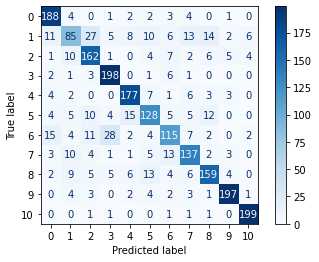

In [44]:
cm = confusion_matrix(y_test, clf.predict(LSA_Test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.savefig('SVM_RF.png', dpi=300)
plt.show()

In [45]:
print(metrics.classification_report(y_test, clf.predict(LSA_Test)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.86       205
           1       0.63      0.45      0.53       187
           2       0.72      0.80      0.76       202
           3       0.81      0.93      0.87       212
           4       0.83      0.87      0.85       203
           5       0.72      0.68      0.70       188
           6       0.71      0.61      0.65       190
           7       0.74      0.77      0.75       179
           8       0.80      0.75      0.77       213
           9       0.92      0.91      0.91       217
          10       0.94      0.98      0.96       204

    accuracy                           0.79      2200
   macro avg       0.78      0.79      0.78      2200
weighted avg       0.79      0.79      0.79      2200



#### XGBoost

In [46]:
xgclf = XGBClassifier()
xgclf.fit(LSA_Train, y_train)

C:\Users\imank\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:10:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [47]:
print(f'Accuracy on Train Data = {xgclf.score(LSA_Train,y_train)*100}%')
print(f'Accuracy on Test Data = {xgclf.score(LSA_Test,y_test)*100}%')

Accuracy on Train Data = 99.95454028866916%
Accuracy on Test Data = 81.54545454545455%


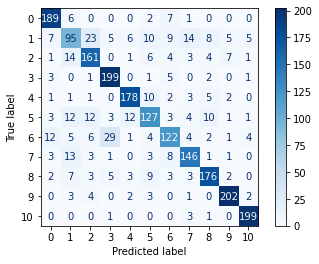

In [48]:
cm = confusion_matrix(y_test, xgclf.predict(LSA_Test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.savefig('SVM_XG.png', dpi=300)
plt.show()

In [49]:
print(metrics.classification_report(y_test, xgclf.predict(LSA_Test)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       205
           1       0.61      0.51      0.55       187
           2       0.75      0.80      0.77       202
           3       0.82      0.94      0.87       212
           4       0.88      0.88      0.88       203
           5       0.73      0.68      0.70       188
           6       0.75      0.64      0.69       190
           7       0.80      0.82      0.81       179
           8       0.84      0.83      0.83       213
           9       0.91      0.93      0.92       217
          10       0.93      0.98      0.95       204

    accuracy                           0.82      2200
   macro avg       0.81      0.81      0.81      2200
weighted avg       0.81      0.82      0.81      2200



#### Gaussian Naive Bayes

In [50]:
clf = GaussianNB()
clf.fit(LSA_Train, y_train)

GaussianNB()

In [51]:
print(f'Accuracy on Train Data = {clf.score(LSA_Train,y_train)*100}%')
print(f'Accuracy on Test Data = {clf.score(LSA_Test,y_test)*100}%')

Accuracy on Train Data = 70.8375951812706%
Accuracy on Test Data = 65.31818181818181%


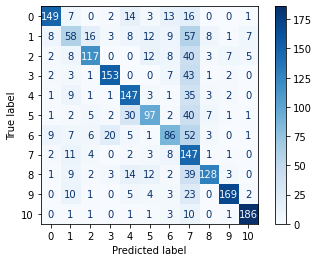

In [52]:
cm = confusion_matrix(y_test, clf.predict(LSA_Test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.savefig('SVM_GNB.png', dpi=300)
plt.show()

In [53]:
print(metrics.classification_report(y_test, clf.predict(LSA_Test)))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78       205
           1       0.46      0.31      0.37       187
           2       0.76      0.58      0.66       202
           3       0.83      0.72      0.77       212
           4       0.65      0.72      0.69       203
           5       0.66      0.52      0.58       188
           6       0.61      0.45      0.52       190
           7       0.29      0.82      0.43       179
           8       0.83      0.60      0.70       213
           9       0.90      0.78      0.84       217
          10       0.92      0.91      0.91       204

    accuracy                           0.65      2200
   macro avg       0.71      0.65      0.66      2200
weighted avg       0.72      0.65      0.67      2200



# END.